## Setup

In [12]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import itertools
from numba import jit, njit
from tqdm.auto import tqdm
from alg.functions import functions
from alg.bits import find_int_number_of_bits, bit_metrics, \
                        bits_to_value, value_to_bits, \
                        bitstring_to_array, array_to_bitstring
from alg.sa import sa, acc_prob_ln, acc_prob_e

from pathlib import Path

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

tqdm.pandas()

root = Path('checkpoints')

## Plot configuration

In [2]:
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.style.use('grayscale')
figsize33 = (17, 10) # (17, 12)
title_fontsize = 30

## Data Loading

In [3]:
from scipy.interpolate import PchipInterpolator

def ind_to_clean_points(ind):
    xs, ys = ind
    xs = np.array([0] + list(xs) + [1])

    xs_to_ys = dict()
    for x, y in zip(xs, ys):
        if x in xs_to_ys.keys():
            xs_to_ys[x].append(y)
        else:
            xs_to_ys[x] = [y]

    new_x = []
    new_y = []
    for x, ys in xs_to_ys.items():
        new_x.append(x)
        new_y.append(np.mean(ys))

    xs = np.array(new_x)
    ys = np.array(new_y)

    ys = ys[np.argsort(xs)]
    xs = xs[np.argsort(xs)]
    return xs, ys

def dense_from_ind(ind):
    xs, ys = ind_to_clean_points(ind)
    pchip = PchipInterpolator(xs, ys)
    xnew = np.linspace(0, 1, num=1000 + 1)
    ynew = pchip(xnew)
    return xnew, ynew

In [4]:
def load_exp1_results(root):
    exp1_root = os.path.join('experiments', 'experiment_1_ln_vs_exp')
    ln_root = os.path.join(exp1_root, f'ln_best')
    
    results = []
    for run_path in os.listdir(ln_root):
        results.append(pd.read_parquet(os.path.join(ln_root, run_path)))
    
    return pd.concat(results).drop(columns=['apf_param', 'p_max'])

old_ln = load_exp1_results('experiments')
old_ln['iter_factor'] = 500

In [14]:
name_to_func = {f.name:f for f in functions}

plots_folder = Path('plots') / 'ga30'
plots_folder.mkdir(exist_ok=True, parents=True)

ga_results_path = 'ga30_results.parquet'
try:
    df = pd.read_parquet(ga_results_path)
except Exception as e:
    print(e, 'Reloading all...')
    data = []
    for exp in tqdm(list(root.glob('*'))):
        history_path = exp / 'history.csv'
        if history_path.exists():
            fname, d, iter_factor, p = exp.stem.split('_')
            d = int(d.split('=')[1])
            iter_factor = int(iter_factor.split('=')[1])
            p = int(p.split('=')[1])
            history = pd.read_csv(history_path)
            a = history[history.min_score==history.min_score.min()]
            a = a[a.mean_score==a.mean_score.min()]
            a = a[a.max_score==a.max_score.min()]
            best_generation = a.generation.values[0]
            best_generation_folder = exp / f'generation={best_generation}'
            best_x = np.load(best_generation_folder / 'best_x.npy')
            best_y = np.load(best_generation_folder / 'best_y.npy')

            xs, ys = ind_to_clean_points((best_x, best_y))

            xnew, ynew = dense_from_ind((best_x, best_y))

            fig, ax = plt.subplots()
            _ = ax.plot(xnew, ynew, '-', label='Pchip')
            _ = ax.plot(xs, ys, 'o')
            _ = ax.legend()
            _ = fig.savefig(plots_folder / f'{exp.stem}.png')
            plt.close()

            def generated_apf(_score, _n_score, T0, k, max_iter, min_score, max_score, t, p_max):
                moment = (k + 1) / max_iter
                x = (_n_score - _score) / (max_score - min_score) * (1 - moment) + moment
                return ynew[round(x * (len(ynew) - 1))]

            target_function = name_to_func[fname]
            max_iter = iter_factor * (d ** 2)

            for _ in range(30):
                sa_scores, accept_probs, outcomes = sa(target_function=target_function.f,
                   lb=target_function.lb, ub=target_function.ub,
                   acc_prob_=generated_apf, T0=-1000, apf_param=-1000, p_max=-1000,
                   n_dims=d, max_iter=max_iter)

                data.append({
                    'target':fname,
                    'n_dims':d,
                    'iter_factor':iter_factor,
                    'p':p,
                    'min_score':np.min(sa_scores)
                })

    df = pd.DataFrame(data)

    df['APF'] = 'GA'
    old_ln['APF'] = 'monotonic_ln'

    df2 = pd.concat([df, old_ln])

    def add_distance_to_min(df):
        df['real_min'] = 0
        df.loc[df.target=='Rana', 'real_min'] = \
            -511.7043 * df.query('target=="Rana"').n_dims + 511.68714
        df.loc[df.target=='Eggholder', 'real_min'] = \
            -915.61991 * df.query('target=="Eggholder"').n_dims + 862.10466
        df['d_min'] = df.min_score - df.real_min
        df.drop(columns='real_min', inplace=True)

    add_distance_to_min(df2)
    df2.to_parquet(ga_results_path)
    df = df2
    
df.p.fillna(0, inplace=True)

[Errno 2] No such file or directory: 'ga30_results.parquet' Reloading...


  0%|          | 0/108 [00:00<?, ?it/s]

In [19]:
name_to_func

{'Sphere': <alg.functions.Function at 0x227341e3cd0>,
 'Bohachevsky': <alg.functions.Function at 0x227341e3d00>,
 'Rosenbrock': <alg.functions.Function at 0x227341e3d30>,
 'Rastrigin': <alg.functions.Function at 0x227341e3d60>,
 'Ackley': <alg.functions.Function at 0x227341e3d90>,
 'Griewangk': <alg.functions.Function at 0x227341e3dc0>,
 'Schwefel': <alg.functions.Function at 0x227341e3c70>,
 'Eggholder': <alg.functions.Function at 0x22734223160>,
 'Rana': <alg.functions.Function at 0x227342456c0>}

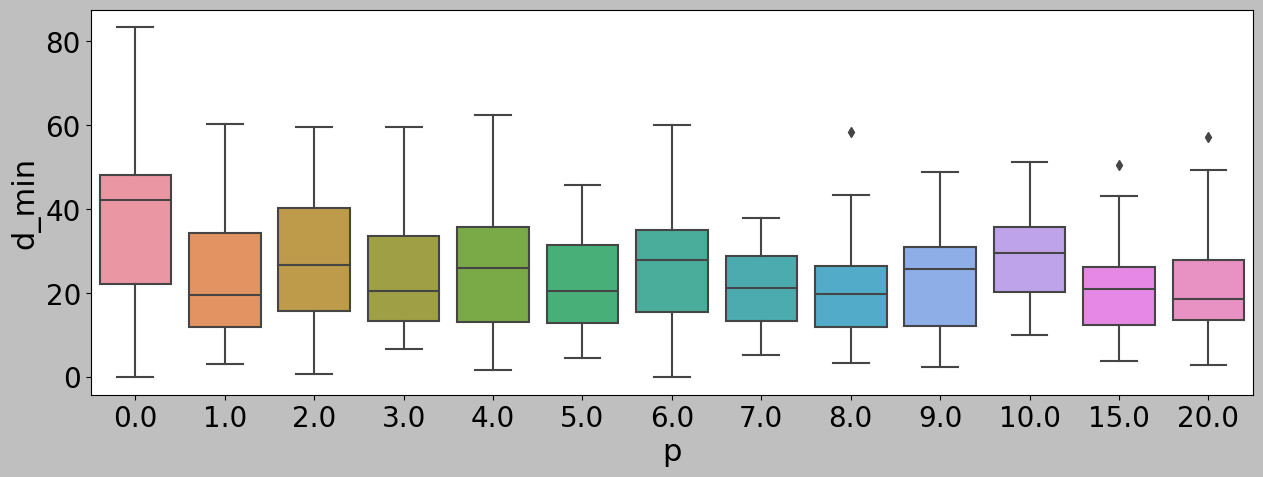

In [29]:
fname = 'Rana'
n_dims = 2
iter_factor = 500
tmp = df.query('target==@fname and n_dims==@n_dims and iter_factor==@iter_factor') \
        .drop(columns=['target', 'n_dims', 'iter_factor'])
_ = sns.boxplot(x='p', y='d_min', data=tmp)

In [31]:
tmp

,p,min_score,APF,d_min
1440,1.0,-473.750088,GA,37.971372
1441,1.0,-480.308127,GA,31.413333
1442,1.0,-485.200104,GA,26.521356
1443,1.0,-453.721185,GA,58.000275
1444,1.0,-472.777963,GA,38.943497
...,...,...,...,...
170,0.0,-511.727348,monotonic_ln,-0.005888
170,0.0,-456.329595,monotonic_ln,55.391865
170,0.0,-459.879009,monotonic_ln,51.842451
170,0.0,-466.576147,monotonic_ln,45.145313


In [32]:
from scipy.stats import ttest_ind

baseline_category = 0
baseline_values = tmp[tmp['p'] == baseline_category]['min_score']

results = {}

# Perform the t-test for each category against the baseline
for category in tmp['p'].unique():
    if category != baseline_category:
        category_values = tmp.query('p==@category')['min_score']
        statistic, p_value = ttest_ind(category_values, baseline_values, alternative='less')
        results[category] = {'statistic': statistic, 'p_value': p_value}

# Create a DataFrame to display the results
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df.index.name = 'Category'

# Display the results DataFrame
print(results_df.sort_values('p_value'))

          statistic   p_value
Category                     
7.0       -4.280183  0.000035
15.0      -4.200339  0.000046
8.0       -4.082242  0.000069
20.0      -3.903105  0.000125
5.0       -3.786473  0.000182
9.0       -3.410015  0.000594
3.0       -3.079541  0.001583
1.0       -3.068232  0.001635
6.0       -2.787603  0.003584
4.0       -2.577898  0.006251
10.0      -2.361090  0.010801
2.0       -2.176428  0.016804


In [36]:
results_df.sort_values('p_value') * results_df.shape[0]

,statistic,p_value
Category,,
7.0,-51.362199,0.000425
15.0,-50.404066,0.000558
8.0,-48.986909,0.000830
20.0,-46.837259,0.001499
5.0,-45.437675,0.002189
9.0,-40.920181,0.007129
3.0,-36.954493,0.018997
1.0,-36.818785,0.019625
6.0,-33.451234,0.043005


In [43]:
df.sample(4)

,target,n_dims,iter_factor,p,min_score,APF,d_min
146,Eggholder,7,500,0.0,-4366.045945,monotonic_ln,1181.188765
45,Rosenbrock,13,500,0.0,12.643885,monotonic_ln,12.643885
91,Ackley,5,500,0.0,0.000020,monotonic_ln,0.000020
1993,Rastrigin,2,500,4.0,1.235823,GA,1.235823


For each function, keep the best p and 0.

In [71]:
data = []
target_to_bestp = dict()
for target in df.target.unique():
    tmp = df.query('target==@target and n_dims==2')
    best_p = tmp.query('p!=0').groupby('p').min_score.apply(np.median).idxmin()
    target_to_bestp[target] = best_p
    _fdf = tmp.query('p==0 or p==@best_p').drop(columns=['n_dims', 'iter_factor', 'p', 'min_score'])
    data.append(_fdf)
df2 = pd.concat(data)

In [128]:
results = {}

for target in df2.target.unique():
    tmp = df2.query('target==@target')
    baseline_values = tmp.query('APF=="monotonic_ln"')['d_min']
    category_values = tmp.query('APF=="GA"')['d_min']
    statistic, p_value = ttest_ind(category_values, baseline_values, alternative='less')
    results[target] = p_value

results = pd.Series(results).rename('p_value').to_frame()
results['adj_p_value'] = results['p_value'] * 12
results

C:\Users\dinus\AppData\Local\Temp\ipykernel_13308\3464230414.py:7: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  statistic, p_value = ttest_ind(category_values, baseline_values, alternative='less')


,p_value,adj_p_value
Ackley,0.860322,10.323869
Bohachevsky,0.897050,10.764599
Eggholder,0.000159,0.001909
Griewangk,0.006172,0.074068
Rana,0.000125,0.001499
Rastrigin,0.016836,0.202033
Rosenbrock,0.024974,0.299684
Schwefel,0.045372,0.544467
Sphere,0.839268,10.071214


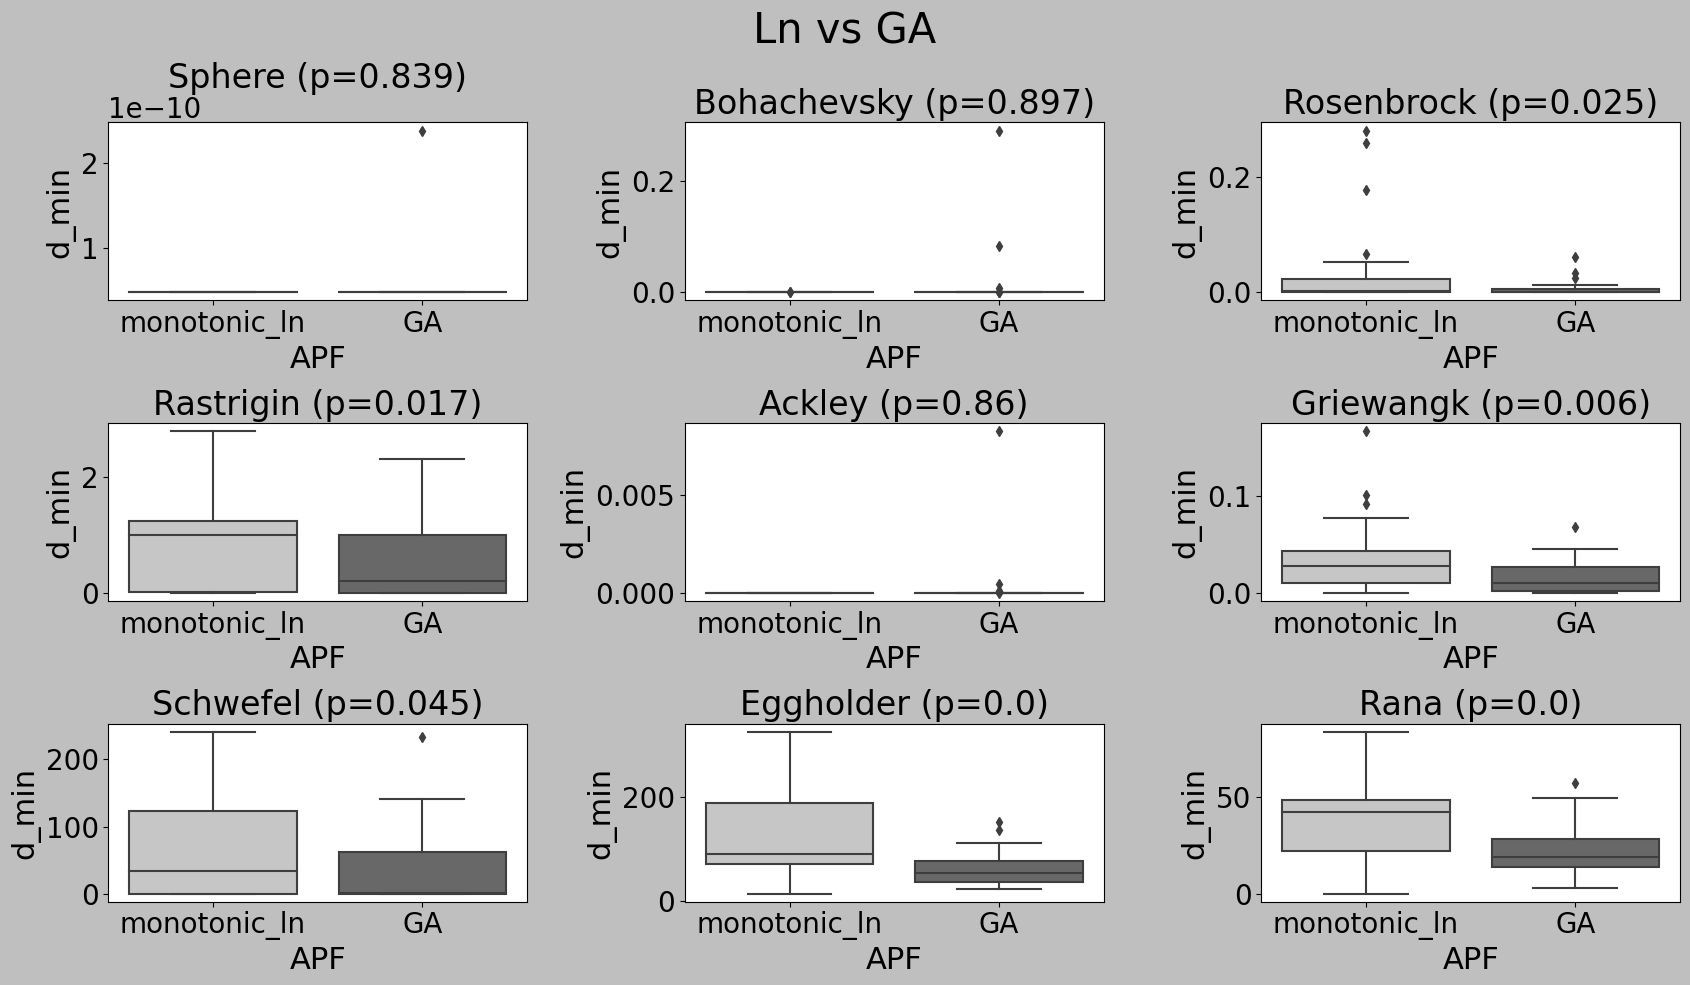

In [135]:
p = results.p_value.to_dict()

fig, ax = plt.subplots(3, 3, figsize=figsize33)
_ = plt.suptitle('Ln vs GA', fontsize=title_fontsize)
for i, target in enumerate(functions):
    _df = df2[df2.target==target.name].sort_values('APF', ascending=False)
    this_ax = ax[i // 3, i % 3]
    _ = sns.boxplot(x='APF', y='d_min', data=_df, ax=this_ax, palette=('Greys'))
    _ = this_ax.set_title(f'{target.name} (p={round(p[target.name], 3)})');
#         _ = this_ax.set_xticklabels(ap_names)
    _ = this_ax.set_xlabel('APF');
    _ = this_ax.set_ylabel('d_min');

fig.tight_layout()
_ = fig.savefig(plots_folder / 'Best_APFs_vs_monotonic_ln.png')

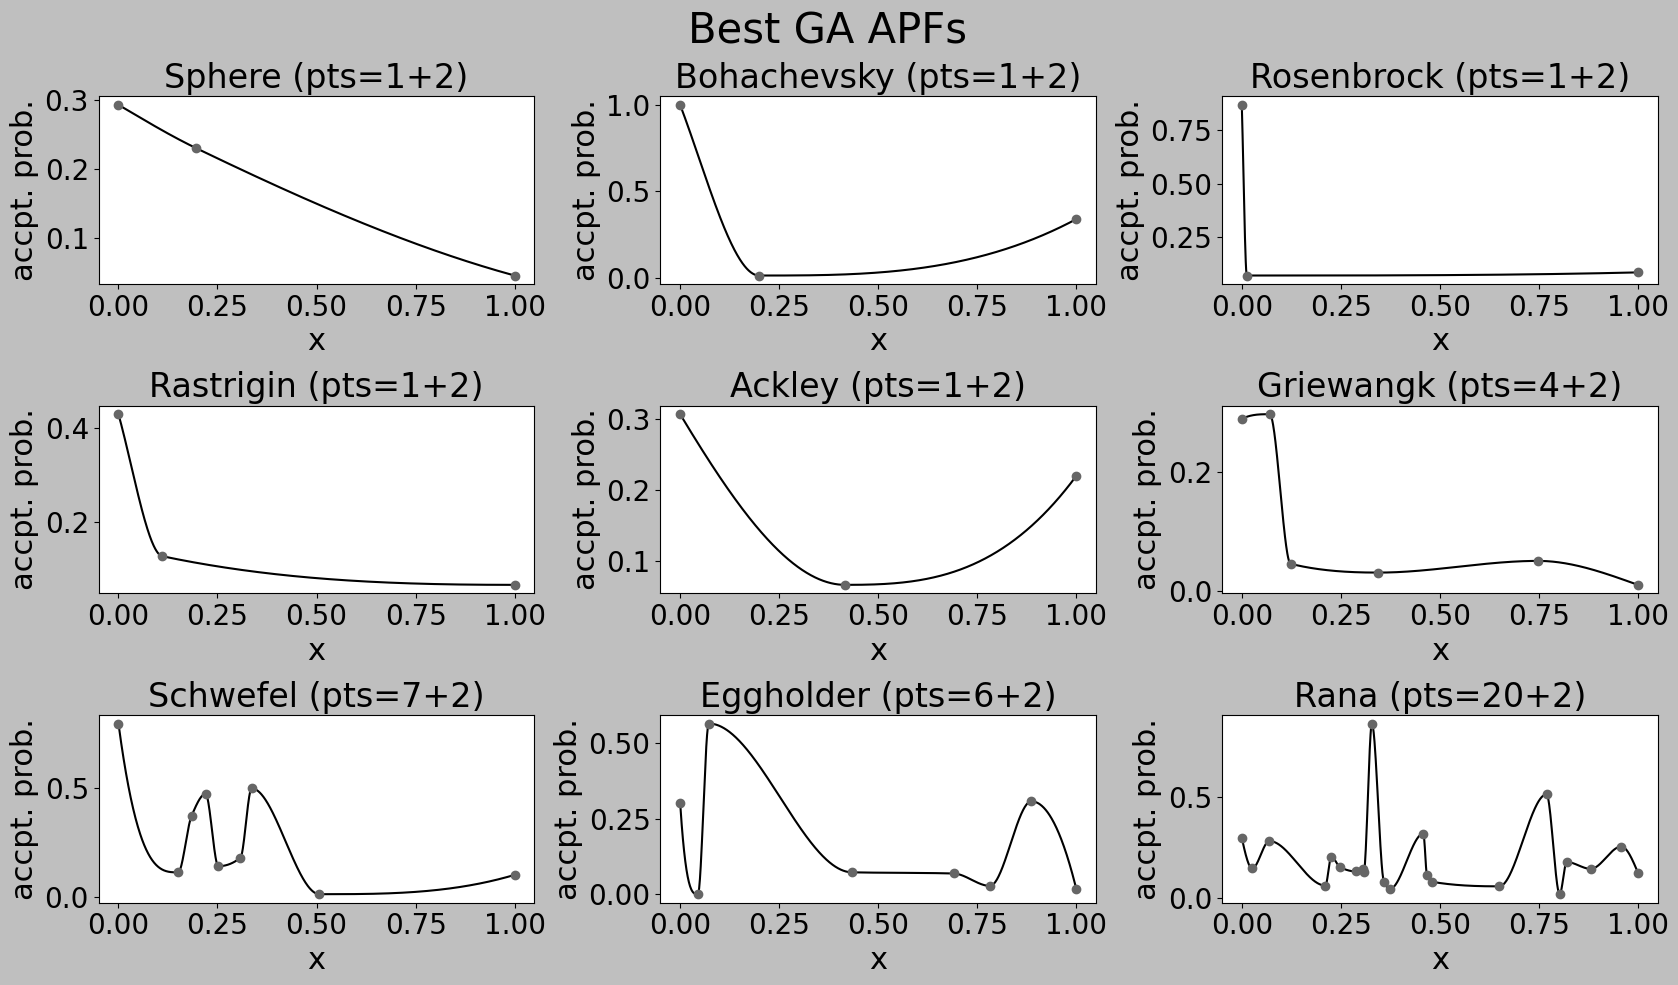

In [134]:
fig, ax = plt.subplots(3, 3, figsize=figsize33)
_ = plt.suptitle('Best GA APFs', fontsize=title_fontsize)

for i, target in enumerate(functions):
    this_ax = ax[i // 3, i % 3]
    best_p = target_to_bestp[target.name]
    exp_root = root / f'{target.name}_d=2_if=500_p={int(best_p)}'
    history = pd.read_csv(exp_root / 'history.csv')
    generation = history[history.min_score == history.min_score.min()].generation.values[-1]
    gen_root = exp_root / f'generation={generation}'
    x = np.load(gen_root / 'best_x.npy')
    y = np.load(gen_root / 'best_y.npy')
    
    xs, ys = ind_to_clean_points((x, y))
    newx, newy = dense_from_ind((x, y))
    _ = this_ax.plot(newx, newy, '-', label='Pchip')
    _ = this_ax.plot(xs, ys, 'o')
    
    _ = this_ax.set_title(f'{target.name} (pts={len(x)}+2)');
    _ = this_ax.set_xlabel('x');
    _ = this_ax.set_ylabel('accpt. prob.');
    
fig.tight_layout()
_ = fig.savefig(plots_folder / 'Best_APFs_found.png')

## Plots.ln vs exp
- [x] boxplots at d=20
- [x] median lineplots at all dimensions

In [57]:
plots_root = 'plots'
os.makedirs(plots_root, exist_ok=True)

def _savefig(fig, filename, experiment):
    experiment_root = os.path.join(plots_root, f'experiment{experiment}')
    upload_root = os.path.join(plots_root, 'upload')
    os.makedirs(experiment_root, exist_ok=True)
    os.makedirs(upload_root, exist_ok=True)
    basename = f'exp{experiment}_{filename}'
    fig.savefig(os.path.join(experiment_root, f'{basename}.eps'), format='EPS')
    fig.savefig(os.path.join(upload_root, f'{basename}.eps'), format='EPS')
    fig.savefig(os.path.join(experiment_root, f'{basename}.png'))

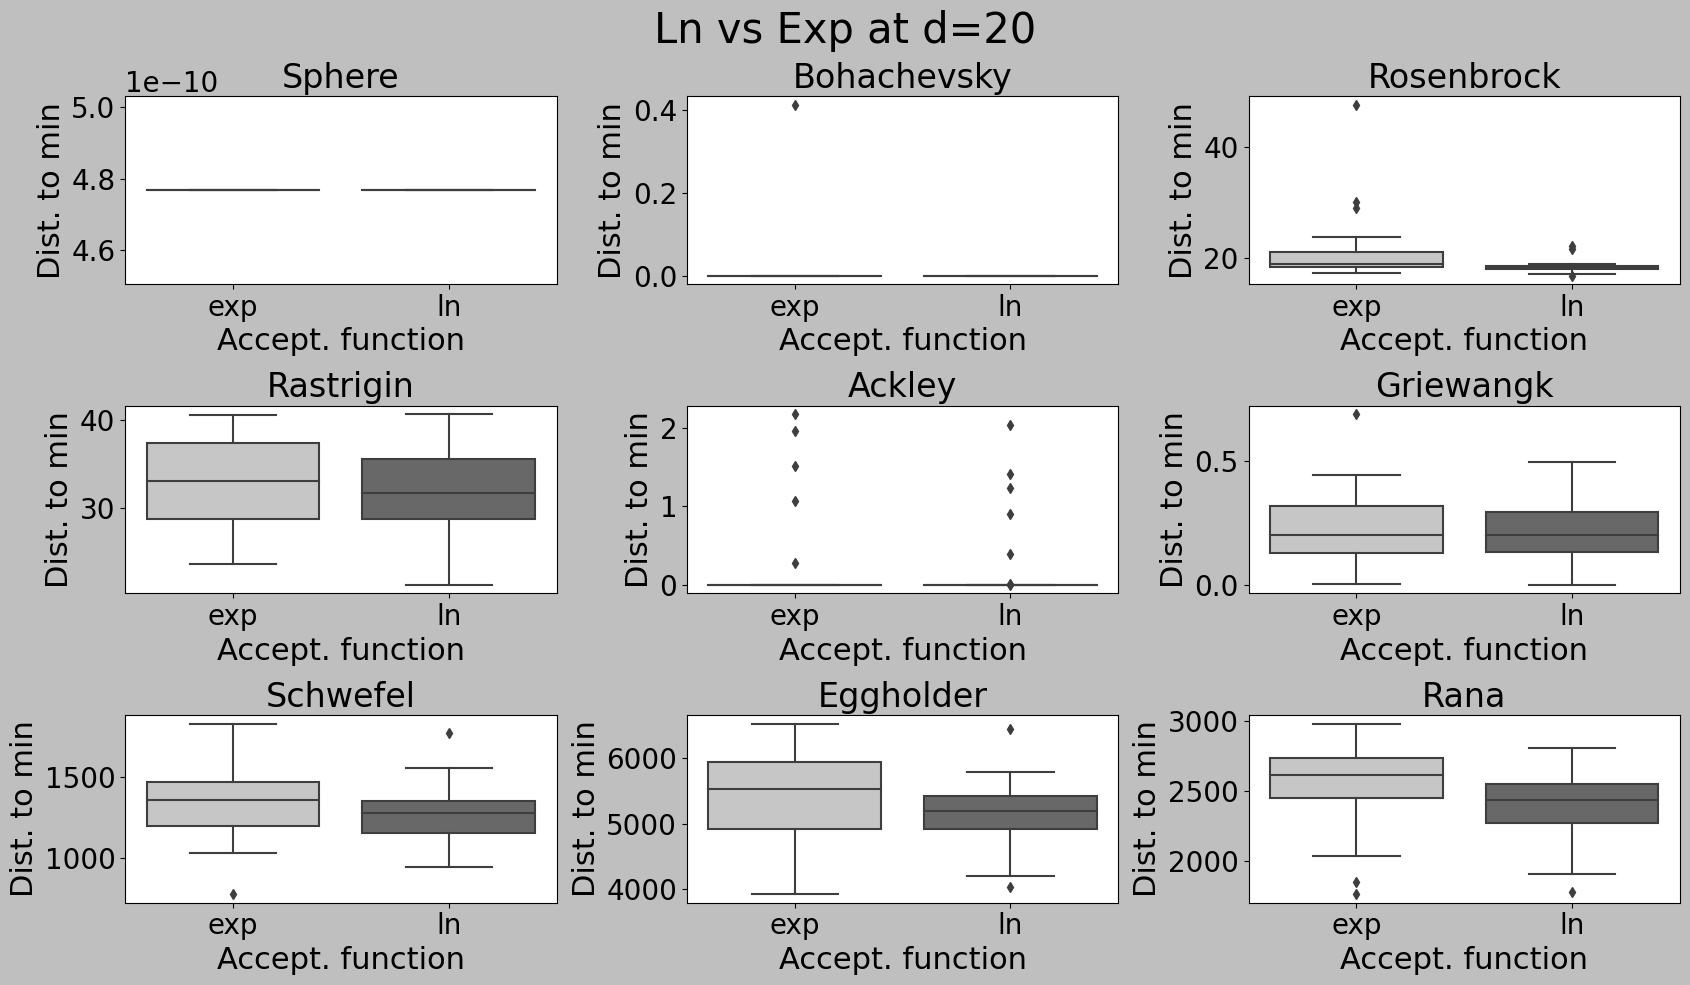

In [10]:
def _boxplot33(data, fig_title, x_col, x_label, y_col, y_label, \
            file_name, experiment):
    fig, ax = plt.subplots(3, 3, figsize=figsize33)
    _ = plt.suptitle(fig_title, fontsize=title_fontsize)
    for i, target in enumerate(functions):
        _df = data[data.target==target.name]
        this_ax = ax[i // 3, i % 3]
        sns.boxplot(x=x_col, y=y_col, data=_df, ax=this_ax, palette=('Greys'));
        this_ax.set_title(target.name);
#         _ = this_ax.set_xticklabels(ap_names)
        this_ax.set_xlabel(x_label);
        this_ax.set_ylabel(y_label);
    fig.tight_layout()
    _savefig(fig, file_name, experiment=experiment)

_boxplot33(data=df2, fig_title='Ln vs GA at d=2', \
           x_col='apf', x_label='Accept. function', \
           y_col='d_min', y_label='Dist. to min', \
           file_name='ln_vs_exp_boxplots', experiment=1)